# Data Preprocessing — PocketQuest
This notebook documents the complete data preprocessing pipeline developed for our PocketQuest project.

## Step 1: Getting the PDBs
Our initial task involves retrieving the PDB files corresponding to our protein-ligand complexes using the RCSB public API.

In [ ]:
# === LIBRARIES ===
import os
import time
import pandas as pd
import requests
from requests.exceptions import RequestException

# === PARAMETERS ===
input_file = "BindingDB_BindingDB_Articles.tsv" #Downloaded from LigandDB 
pdb_column = "PDB ID(s) for Ligand-Target Complex" #We want to get the PDB IDs of the protein-ligand article curated complexes
output_dir = "PDB_Files"
max_pdbs = 4000 #Limit to 4K because of computational costs 
retry_limit = 3
delay_between_downloads = 0.2  

# === READ BINDINGDB TSV FILE ===
print("Reading TSV...")
df = pd.read_csv(input_file, sep="\t", on_bad_lines="skip", low_memory=False)

if pdb_column not in df.columns:
    print(f"Column '{pdb_column}' not found.")
    exit()

# Keep only rows that have a non-empty PDB ID
df = df[df[pdb_column].notna() & (df[pdb_column].str.strip() != "")]

# === EXTRACT 4000 UNIQUE PDB IDs ===
print("Extracting unique PDB IDs...")
unique_pdbs = set()

for ids in df[pdb_column]:
    for pdb_id in str(ids).replace(',', ';').split(';'):
        pdb_id = pdb_id.strip().upper()
        if pdb_id and pdb_id not in unique_pdbs:
            unique_pdbs.add(pdb_id)
            if len(unique_pdbs) == max_pdbs:
                break
    if len(unique_pdbs) == max_pdbs:
        break

print(f"Collected {len(unique_pdbs)} unique PDB IDs.")

# === CREATE OUTPUT FOLDER ===
os.makedirs(output_dir, exist_ok=True)

# === DOWNLOAD PDB FILES WITH RETRIES ===
#In this part a lot of log messages where directed in the stdout so we know how the connection with the API and download process are going
print("Starting download of PDB files...")
for pdb_id in unique_pdbs:
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    dest_file = os.path.join(output_dir, f"{pdb_id}.pdb")

    if os.path.exists(dest_file):
        print(f"Skipped (already exists): {pdb_id}.pdb")
        continue

    for attempt in range(1, retry_limit + 1):
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                with open(dest_file, "w") as f:
                    f.write(response.text)
                print(f"Downloaded: {pdb_id}.pdb")
                break  # success
            else:
                print(f"HTTP error {response.status_code} for {pdb_id}")
                break  # do not retry on bad status
        except RequestException as e:
            print(f"Retry {attempt}/{retry_limit} for {pdb_id} — {e}")
            time.sleep(2)
    else:
        print(f"Failed after {retry_limit} attempts: {pdb_id}")

    time.sleep(delay_between_downloads)

# === SAVE DOWNLOADED LIST ===
with open("downloaded_pdbs.txt", "w") as f:
    for pdb in sorted(unique_pdbs):
        f.write(pdb + "\n")              #useful to get all the PDB codes of the downloaded PDBs on a list

print(f"\n All downloads completed. Files saved in '{output_dir}/'")



## Step 2: Ligand identification, Binding Site Extraction & Filtering
The following code block performs three critical tasks in one go: identifying ligands, extracting their binding sites, and applying a filtering process.

In [ ]:

# === LIBRARIES ===
import os
import pandas as pd
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis.distances import distance_array
from collections import defaultdict, Counter
from Bio.SeqUtils import seq1

# === LOGGING ===
log_file = open("ligand_detection_log.txt", "w") ##Very very important, in the very end of the log there are some stats of the filtering process too
def log(msg):
    print(msg)
    log_file.write(msg + "\n")

# === PARAMETERS ===
pdb_folder = "PDB_Files"
output_csv = "binding_sites.csv" #This will contain the binding sites of each pdb code per ligand and they are going to be specified by residue type number and chain e.g. ASN_253_A
distance_cutoff = 4.0  # Known Angstrom distance used in literature to define Binding Sites
centroid_distance_cutoff = 4.0  # Å for centroid-based merging, used in merging very close bs into one

# === Full exclusion list ===
exclude_resnames = {
    # Standard amino acids
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE",
    "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL", "SEC", "PYL",

    # Nucleotides
    "DA", "DG", "DC", "DT", "DI", "A", "G", "C", "U", "I",

    # Water and common ions
    "HOH", "WAT", "DOD", "CL", "NA", "K", "CA", "MG", "MN", "FE", "ZN", "CU", "CD", "CO",
    "SO4", "NO3", "CO3", "BO4", "SCN", "IOD", "BR", "F", "IO3",

    # Sugars and glycans
    "NAG", "MAN", "BMA", "FUC", "NDG", "GLC", "GAL", "SUC", "TRE", "FRU",

    # Ions and metals
    "SE", "KR", "NI", "AS", "D", "YB", "RU", "HG", "HG2", "LI", "BA", "SR", "RA", "AL",
    "PB", "BI", "SN", "SB", "CS", "U",

    # Unspecified/ambiguous (keep excluding UNK due to modified ligands default)
    "UNK"
}


# === IDENTIFY HOMOMERIC CHAINS (REMOVE EXCEPT IF HOLDING UNIQUE LIGAND) ===
alt_resname_map = {
    "HSD": "HIS", "HSE": "HIS", "HIP": "HIS",
    "MSE": "MET"
}  #this is very useful because some amino acids if specified by their second name e.g. HSD instead of HIS they are sometimes identified as HETATM (heteroatoms) and not part of the protein

valid_aa_3letter = {
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY",
    "HIS", "HSD", "HSE", "HIP",
    "ILE", "LEU", "LYS", "MET", "MSE",
    "PHE", "PRO", "SER", "THR",
    "TRP", "TYR", "VAL", "SEC", "PYL"
}

def get_chain_sequence(residues):
    sequence = []
    for res in residues:
        resname = res.resname
        if resname in valid_aa_3letter:
            canonical = alt_resname_map.get(resname, resname)
            try:
                sequence.append(seq1(canonical))
            except Exception:
                continue
    return "".join(sequence) #We define as homomeric the chains that have identical sequence inside a PDB File

def identify_unique_chain_ids(universe, ligand_residues=None, distance_cutoff=4.0):
    from Bio import pairwise2

    seen_sequences = []
    ligand_counts = Counter(res.resname for res in ligand_residues) if ligand_residues else Counter()
    singleton_ligands = {res for res, count in ligand_counts.items() if count == 1} #singleton ligands are ligands that only bind in one chain
    ligand_nearby_chains = set()

    if ligand_residues:
        for ligand_res in ligand_residues:
            if ligand_res.resname not in singleton_ligands:
                continue
            ligand_atoms = ligand_res.atoms
            for seg in universe.segments:
                seg_atoms = seg.atoms.select_atoms("protein and not name H*")
                if len(seg_atoms) == 0:
                    continue
                try:
                    dists = distance_array(ligand_atoms.positions, seg_atoms.positions)
                    if np.any(dists < distance_cutoff):
                        ligand_nearby_chains.add(seg.segid)
                except Exception:
                    continue

    unique_chain_ids = []
    for seg in universe.segments:
        seq = get_chain_sequence(seg.residues)
        if not seq:
            continue
        is_duplicate = False
        for seen_seq in seen_sequences:
            alignments = pairwise2.align.globalxx(seq, seen_seq)
            identity = alignments[0][2] / max(len(seq), len(seen_seq))
            if identity >= 0.99:
                is_duplicate = True
                break
        if not is_duplicate or seg.segid in ligand_nearby_chains:
            seen_sequences.append(seq)
            unique_chain_ids.append(seg.segid)
    return unique_chain_ids

# === FINAL FILTERING ===

#We apply two basic rules among others in this filtering:
#If 2 binding sites of the same pdb correspond to the same ligand and have 70% identity or more we collapse them in one because some of these structures contain small molecules that are more than one in the file
#If 2 binding sites of the same pdb correspond to the same ligand and don't hvae 70% or more identity but their centroids are closer than 4 Angstroms we also collapse them in one binding site.


def compute_binding_site_centroid(universe, residues):
    atoms = universe.select_atoms(" or ".join([
        f"(resname {res.split('_')[0]} and resid {res.split('_')[1]})"
        for res in residues
    ]))
    if len(atoms) == 0:
        return None
    return atoms.positions.mean(axis=0)

def remove_redundant_sites(results, pdb_folder, overlap_thresh=0.7):
    grouped = defaultdict(list)
    for entry in results:
        key = (entry["pdb_id"], entry["ligand"])
        grouped[key].append(entry)

    filtered = []

    for (pdb_id, ligand), sites in grouped.items():
        pdb_path = os.path.join(pdb_folder, f"{pdb_id}.pdb")
        try:
            u = mda.Universe(pdb_path)
        except Exception as e:
            log(f"Error loading {pdb_id}: {e}")
            continue

        kept_sites = []

        for site in sites:
            current_set = set(site["binding_residues"].split(";"))
            merged = False

            for kept in kept_sites:
                kept_set = set(kept["binding_residues"].split(";"))
                intersection = current_set & kept_set
                overlap = len(intersection) / min(len(current_set), len(kept_set))

                if overlap >= overlap_thresh:
                    kept["binding_residues"] = ";".join(sorted(current_set | kept_set))
                    merged = True
                    break

                disjoint_current = current_set - kept_set
                disjoint_kept = kept_set - current_set

                if disjoint_current and disjoint_kept:
                    centroid1 = compute_binding_site_centroid(u, disjoint_current)
                    centroid2 = compute_binding_site_centroid(u, disjoint_kept)
                    if centroid1 is not None and centroid2 is not None:
                        dist = np.linalg.norm(centroid1 - centroid2)
                        if dist <= centroid_distance_cutoff:
                            kept["binding_residues"] = ";".join(sorted(current_set | kept_set))
                            merged = True
                            break

            if not merged:
                kept_sites.append(site)

        filtered.extend(kept_sites)

    return filtered
#We only keep two ligands per pdb that have the bigger number of atoms (trying to discard non biologically relevant ligands)
def keep_top_two_ligands(results):
    final_results = []
    grouped = defaultdict(list)
    for entry in results:
        grouped[entry["pdb_id"]].append(entry)
    for pdb_id, entries in grouped.items():
        top_two = sorted(entries, key=lambda x: x["n_residues"], reverse=True)[:2]
        final_results.extend(top_two)
    return final_results

# === MAIN LOOP ===
results = []
for filename in os.listdir(pdb_folder):
    if not filename.endswith(".pdb"):
        continue

    pdb_id = filename[:4].upper()
    pdb_path = os.path.join(pdb_folder, filename)

    try:
        u = mda.Universe(pdb_path)

        all_ligand_atoms = u.select_atoms(
            f"not protein and not resname {' '.join(exclude_resnames)} and not name H*"
        )
        ligand_residues = [res for res in all_ligand_atoms.residues if len(res.atoms) >= 5] #We discard all possible ligands with less than 5 atoms

        if not ligand_residues:
            log(f"No valid ligand found in {pdb_id}")
            continue

        unique_chain_ids = identify_unique_chain_ids(u, ligand_residues=ligand_residues)
        protein_atoms = u.select_atoms(f"protein and segid {' '.join(unique_chain_ids)} and not name H*")

        if len(protein_atoms) == 0:
            log(f"No protein atoms found in {pdb_id}")
            continue
        #Now we will get all residues close to the ligands (bs residues)
        for ligand_res in ligand_residues:
            ligand_atoms = ligand_res.atoms
            dists = distance_array(ligand_atoms.positions, protein_atoms.positions)
            close_contacts = (dists < distance_cutoff)

            close_atom_indices = {
                protein_atoms[j].index
                for i in range(close_contacts.shape[0])
                for j in range(close_contacts.shape[1])
                if close_contacts[i, j]
            }

            binding_residues = {
                f"{u.atoms[idx].residue.resname}_{u.atoms[idx].residue.resid}_{u.atoms[idx].residue.segid}"
                for idx in close_atom_indices
            }

            if len(binding_residues) < 5:
                continue

            results.append({
                "pdb_id": pdb_id,
                "ligand": ligand_res.resname,
                "ligand_resid": ligand_res.resid,
                "binding_residues": ";".join(sorted(binding_residues)),
                "n_residues": len(binding_residues)
            })

            log(f"{pdb_id} | Ligand: {ligand_res.resname} {ligand_res.resid} | Residues: {len(binding_residues)}")

    except Exception as e:
        log(f"Failed for {pdb_id}: {e}")
        continue

# === RUN FINAL FILTERS AND SAVE ===
filtered_results = remove_redundant_sites(results, pdb_folder)
filtered_results = keep_top_two_ligands(filtered_results)

pd.DataFrame(filtered_results).to_csv(output_csv, index=False)

# === REPORTING ===
log(f"Total initial sites: {len(results)}")
log(f"Total after filtering: {len(filtered_results)}")

#This will be written in the log!!

if filtered_results:
    df = pd.DataFrame(filtered_results)
    log(f"Average residues per site: {df['n_residues'].mean():.2f}")
    log(f"Max residues per site: {df['n_residues'].max()}")
    log(f"Min residues per site: {df['n_residues'].min()}")
    most_common_ligands = df['ligand'].value_counts().head(5)
    log("Top 5 ligands:")
    for lig, count in most_common_ligands.items():
        log(f"  {lig}: {count}")

log(f"Done! Results saved to {output_csv}")
log_file.close()


## Step 3: Protein Classes Distribution
To gain insight into the composition of our dataset, we classified the PDB structures into broader protein categories. This was done by mapping Uniprot IDs and then using the PANTHER classification system.

In [ ]:
import requests
import pandas as pd
import time

# Input and output file paths
input_csv = "binding_sites.csv"  
output_csv = "pdb_uniprot_mapping.csv" #important file so then we can do the pdb to panther mapping

# Read input CSV
df = pd.read_csv(input_csv)
if 'pdb_id' not in df.columns:
    raise ValueError("Column 'pdb_id' not found in the input CSV")

# Get unique PDB IDs, we first inspected what is the structure of the array returned by the API in order to get the following code correct
unique_pdb_ids = df['pdb_id'].dropna().unique()

def fetch_uniprot_ids(pdb_id):
    url = f"https://data.rcsb.org/rest/v1/core/entry/{pdb_id.lower()}"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve data for {pdb_id}")
        return []

    data = response.json()
    entity_ids = data.get("rcsb_entry_container_identifiers", {}).get("polymer_entity_ids", [])
    uniprot_ids = set()

    for entity_id in entity_ids:
        entity_url = f"https://data.rcsb.org/rest/v1/core/polymer_entity/{pdb_id.lower()}/{entity_id}"
        entity_resp = requests.get(entity_url)
        if entity_resp.status_code != 200:
            continue

        entity_data = entity_resp.json()
        ref_ids = entity_data.get("rcsb_polymer_entity_container_identifiers", {}).get("reference_sequence_identifiers", [])
        for ref in ref_ids:
            if ref.get("database_name") == "UniProt":
                uniprot_ids.add(ref.get("database_accession"))

    return list(uniprot_ids)


# Process each PDB ID
output_rows = []
for pdb_id in unique_pdb_ids:
    uniprot_ids = fetch_uniprot_ids(pdb_id)
    if uniprot_ids:
        output_rows.append({"PDB_ID": pdb_id.upper(), "UniProt_IDs": "; ".join(uniprot_ids)})
        print(f"✅ {pdb_id}: Found UniProt IDs: {', '.join(uniprot_ids)}")
    else:
        print(f"{pdb_id}: No UniProt IDs found")
    time.sleep(0.1)  # To avoid overwhelming the server

# Save results to CSV
if output_rows:
    out_df = pd.DataFrame(output_rows)
    out_df.to_csv(output_csv, index=False)
    print(f"Saved UniProt mappings to {output_csv}")
else:
    print("No UniProt IDs were found for any PDB entries.")


## Step 4: PANTHER
Once the Uniprot IDs were extracted, they were uploaded to the PANTHER classification tool. The results were saved in a file named pantherGeneList (1).txt, which follows a specific format. The next code block parses this file to help stratify our initial batches.

In [ ]:
import pandas as pd
import re

# === Load Panther Classification File ===
panther_df = pd.read_csv("pantherGeneList (1).txt", sep="\t", dtype=str)

# Extract UniProt ID and Panther Protein Class
panther_df = panther_df.iloc[:, [1, 4]]
panther_df.columns = ["UniProt_ID", "Panther_Protein_Class"]

# Extract Panther code and clean class name
panther_df["Panther_Code"] = panther_df["Panther_Protein_Class"].apply(
    lambda x: re.search(r"\(PC\d+\)", x).group(0).strip("()") if pd.notnull(x) and re.search(r"\(PC\d+\)", x) else None
)
panther_df["Panther_Protein_Class"] = panther_df["Panther_Protein_Class"].apply(
    lambda x: re.sub(r"\(PC\d+\)", "", x).strip() if pd.notnull(x) else x
)

# Drop duplicates
panther_df = panther_df.drop_duplicates()

# === Load PDB–UniProt Mapping ===
pdb_uniprot_df = pd.read_csv("pdb_uniprot_mapping.csv")

# === Merge and remove non-matches ===
merged = pdb_uniprot_df.merge(
    panther_df, how="left", left_on="UniProt_IDs", right_on="UniProt_ID"
)

# Remove rows with no Panther match
merged = merged.dropna(subset=["Panther_Protein_Class", "Panther_Code"])

# === Select and export columns ===
final_df = merged[["PDB_ID", "Panther_Protein_Class", "Panther_Code"]].drop_duplicates()
final_df.to_csv("pdb_to_panther_filtered.csv", index=False)

print("Saved 'pdb_to_panther_filtered.csv' with only PDBs mapped to Panther classes.")


## Step 5: Protein Class Counts 
With PANTHER classifications now mapped to each PDB entry, we can analyze the distribution of protein classes and quantify how many structures fall into each category.

In [ ]:
import pandas as pd
from collections import Counter

# Load the filtered mapping file
df = pd.read_csv("pdb_to_panther_filtered.csv")

# Count occurrences of each protein class
counts = df["Panther_Protein_Class"].value_counts().reset_index()
counts.columns = ["Panther_Protein_Class", "Count"]

# Save to CSV
counts.to_csv("panther_class_counts.csv", index=False)

print("Saved counts to 'panther_class_counts.csv'")


## Step 6: Filter out PDBs with no available PANTHER classification
Ultimately, our focus is on understanding the biological relevance of our dataset. Therefore, we filter out any PDB entries that lack a corresponding PANTHER classification.

In [ ]:
import pandas as pd
import shutil
import os

# === File and folder paths ===
filtered_csv = "pdb_to_panther_filtered.csv"
source_folder = "Final_PDBs"
destination_folder = "After_Panther"

# === Read PDB IDs from filtered CSV ===
df = pd.read_csv(filtered_csv)
pdb_ids = df["PDB_ID"].dropna().unique()

# === Copy matching PDB files ===
copied = 0
for pdb_id in pdb_ids:
    pdb_filename = f"{pdb_id.upper()}.pdb"
    source_path = os.path.join(source_folder, pdb_filename)
    dest_path = os.path.join(destination_folder, pdb_filename)
    
    if os.path.exists(source_path):
        shutil.copy(source_path, dest_path)
        copied += 1
        print(f"Copied: {pdb_filename}")
    else:
        print(f"Not found: {pdb_filename}")

print(f"\nFinished copying {copied} PDB files to '{destination_folder}'")


## Step 7: Visualize Protein Class Distribution
At this stage, we visualize the PANTHER protein class distribution to better understand the functional diversity within our dataset.

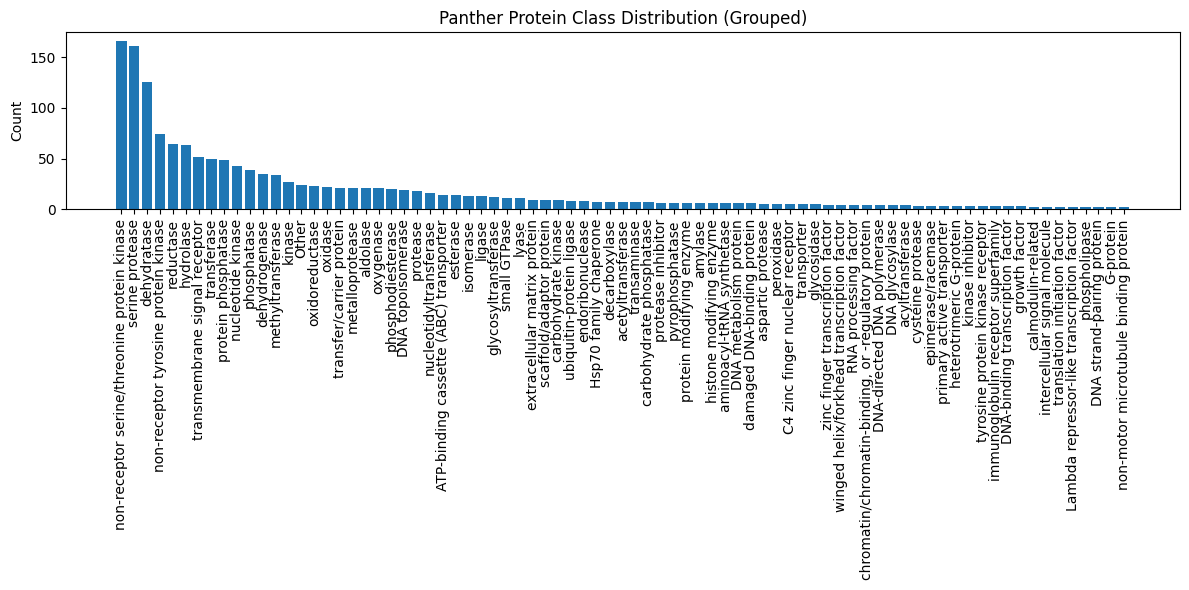

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# === Load the filtered Panther mapping ===
df = pd.read_csv("pdb_to_panther_filtered.csv")

# === Count occurrences of each class ===
counts = Counter(df["Panther_Protein_Class"].dropna())

# === Group classes with count == 1 as 'Other' === 
#We had a big number of different classes with only one count so we grouped them in another group called 'other'
grouped_counts = {}
other_total = 0

for class_name, count in counts.items():
    if count == 1:
        other_total += 1
    else:
        grouped_counts[class_name] = count

if other_total > 0:
    grouped_counts["Other"] = other_total

# === Convert to DataFrame and sort ===
plot_df = pd.DataFrame(list(grouped_counts.items()), columns=["Panther_Protein_Class", "Count"])
plot_df = plot_df.sort_values(by="Count", ascending=False)

# === Plot ===
plt.figure(figsize=(12, 6))
plt.bar(plot_df["Panther_Protein_Class"], plot_df["Count"])
plt.xticks(rotation=90)
plt.title("Panther Protein Class Distribution (Grouped)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("panther_class_distribution.png")
plt.show()


## Step 8: Split in 15 batches
To streamline downstream processing, we split the dataset into 15 stratified batches, each designed to maintain similar proportions of protein classes.

In [ ]:
import pandas as pd
import random
import os

# === Load Panther filtered annotations ===
df = pd.read_csv("pdb_to_panther_filtered.csv")

# === Optional: Only keep existing PDBs ===
pdb_folder = "After_Panther"
existing_pdbs = set(f.replace(".pdb", "") for f in os.listdir(pdb_folder) if f.endswith(".pdb"))
df = df[df["PDB_ID"].isin(existing_pdbs)]

# === Group PDBs by Panther class and shuffle ===
grouped = df.groupby("Panther_Protein_Class")
shuffled_pdbs = []

for _, group in grouped:
    pdbs = list(group["PDB_ID"])
    random.shuffle(pdbs)
    shuffled_pdbs.extend(pdbs)

# === Final shuffle for randomness across classes ===
random.shuffle(shuffled_pdbs)

# === Split into 15 nearly equal batches ===
num_batches = 15
batch_size = len(shuffled_pdbs) // num_batches
remainder = len(shuffled_pdbs) % num_batches

batches = []
start = 0
for i in range(num_batches):
    size = batch_size + (1 if i < remainder else 0)
    batch = shuffled_pdbs[start:start+size]
    batches.append(batch)
    start += size

# === Save each batch ===
for i, batch in enumerate(batches):
    df_batch = pd.DataFrame(batch, columns=["PDB_ID"])
    df_batch.to_csv(f"batch_{i+1}_balanced.csv", index=False)
    print(f"Saved batch_{i+1}_balanced.csv with {len(batch)} PDBs")


## Step 9: Visualization Scripts for Chimera
At this stage, we realized that although we had applied extensive filtering and binding site extraction, we had not visually verified the quality of the results. To address this, we developed Python scripts to automatically generate .cmd files for Chimera, batch by batch. These scripts load each structure in Chimera, apply distinct coloring to the ligand and its corresponding binding site, and capture a screenshot. By reviewing these images, we were able to visually assess whether our binding site definitions were accurate and exclude any low-quality structures that would not contribute meaningful value to the machine learning model.

In [ ]:
import pandas as pd
import os

# Folder with batch files
batch_folder = "."
# Folder with PDBs
final_pdbs_dir = os.path.abspath("After_Panther")

# Loop through the 15 batch files
for i in range(1, 16):
    batch_file = f"binding_sites_batch_{i}.csv"
    chimera_cmd_file = f"visualize_batch_{i}.cmd"

    # Load the batch
    df = pd.read_csv(os.path.join(batch_folder, batch_file))

    with open(chimera_cmd_file, "w") as f:
        for index, row in df.iterrows():
            pdb_id = row["pdb_id"]
            ligand = row["ligand"]
            binding_residues = row["binding_residues"].split(";")

            # Path to the corresponding PDB file
            pdb_path = os.path.join(final_pdbs_dir, f"{pdb_id}.pdb")
            f.write(f"open {pdb_path}\n")

            # Color binding residues
            for residue in binding_residues:
                residue_parts = residue.split('_')
                if len(residue_parts) == 3:
                    residue_number, chain = residue_parts[1], residue_parts[2]
                    f.write(f"color magenta :{residue_number}.{chain}\n") #magenta is the binding site
                else:
                    print(f"Skipping invalid residue format: {residue}")

            # Color ligand
            f.write(f"color cyan :{ligand}\n") #sometimes even chimera's algorithms does not find the ligand correctly though but it mostly works well
            # Save image
            f.write(f"copy file {pdb_id}_binding_sites.png\n") #get a screenshot
            # Close all
            f.write("close all\n\n")

    print(f"Chimera script saved: {chimera_cmd_file}")

## Step 10: Discard low quality PDB files after Chimera vizualization
Following the generation of the Chimera .cmd scripts, we loaded all 15 files via the Chimera command line to visualize the binding sites for the 1,432 PDB structures that remained after PANTHER classification. Each image was manually inspected, and we retained 1,081 high-quality, well-defined structures deemed suitable for training our model. Since this visual inspection served as an additional filtering step, we now needed to update our dataset accordingly. The next task was to remove the low-quality PDBs (those listed in low_quality.txt) from our batches. After this cleanup, we planned to merge the remaining PDBs and re-stratify them into 10 balanced batches, ensuring each batch maintains a similar distribution of protein functional classes.

In [ ]:
# == Libraries ==
import os
import pandas as pd

#Define paths
low_quality_path = "screenshots/low_quality.txt"
csv_path = "pdb_to_panther_filtered.csv"
after_panther_dir = "After_Panther"
screenshots_dir = "screenshots"

#Parse the low_quality.txt file
batch_to_pdbs = {}
current_batch = None

with open(low_quality_path, "r") as file:
    for line in file:
        line = line.strip()
        if line.startswith("batch_"):
            current_batch = line
            batch_to_pdbs[current_batch] = []
        elif line and current_batch:
            batch_to_pdbs[current_batch].append(line)

low_quality_pdbs = set(pdb for lst in batch_to_pdbs.values() for pdb in lst)

#Filter CSV
if os.path.isfile(csv_path):
    df = pd.read_csv(csv_path)
    original_len = len(df)
    df_filtered = df[~df["PDB_ID"].isin(low_quality_pdbs)]
    df_filtered.to_csv(csv_path, index=False)
    print(f"Removed {original_len - len(df_filtered)} entries from {csv_path}")
else:
    print(f"File not found: {csv_path}")

#Delete PDB files from After_Panther
pdb_deleted = 0
for pdb in low_quality_pdbs:
    pdb_file = os.path.join(after_panther_dir, f"{pdb}.pdb")
    if os.path.exists(pdb_file):
        os.remove(pdb_file)
        pdb_deleted += 1
print(f"🗑️ Deleted {pdb_deleted} PDB files from {after_panther_dir}/")

#Delete screenshots from screenshots/batch_X/
screenshots_deleted = 0
for batch, pdb_list in batch_to_pdbs.items():
    batch_folder = os.path.join(screenshots_dir, batch)
    if not os.path.isdir(batch_folder):
        print(f"Folder not found: {batch_folder}")
        continue
    for pdb in pdb_list:
        image_name = f"{pdb}_binding_sites.png"
        image_path = os.path.join(batch_folder, image_name)
        if os.path.exists(image_path):
            os.remove(image_path)
            screenshots_deleted += 1
print(f"Deleted {screenshots_deleted} screenshot files from {screenshots_dir}/batch_X folders")


## Step 11: Get Protein Class Counts for the final dataset

In [ ]:
import pandas as pd
from collections import Counter

# Load the filtered mapping file
df = pd.read_csv("pdb_to_panther_filtered.csv")

# Count occurrences of each protein class
counts = df["Panther_Protein_Class"].value_counts().reset_index()
counts.columns = ["Panther_Protein_Class", "Count"]

# Save to CSV
counts.to_csv("panther_class_counts.csv", index=False)

print("Saved counts to 'panther_class_counts.csv'")

## Step 12: Check Class Distribution in the final dataset

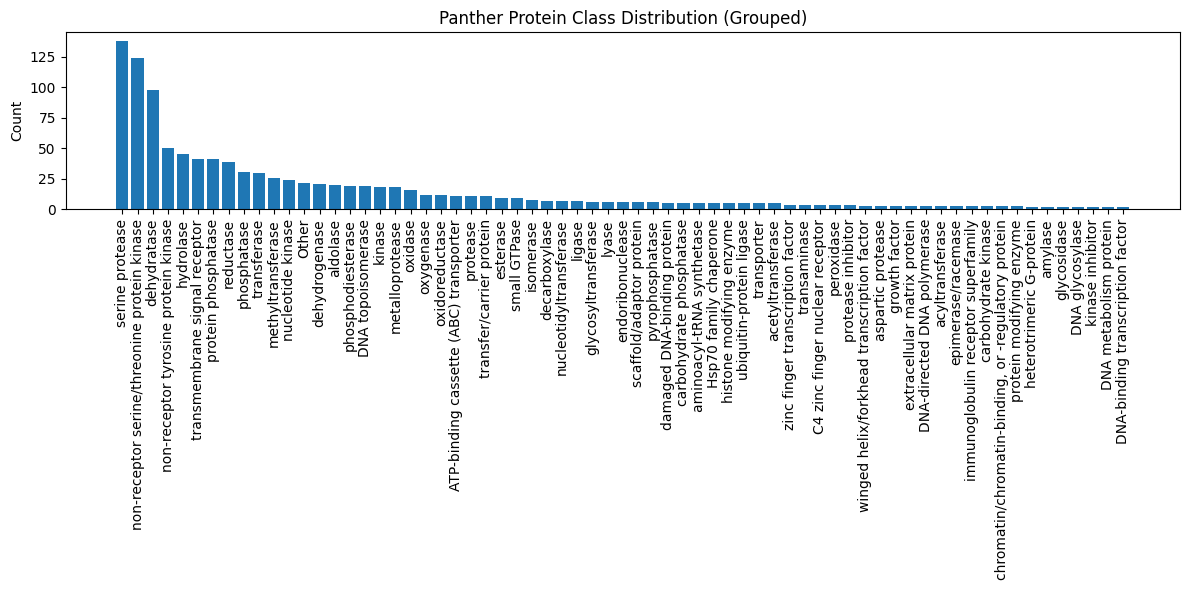

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# === Load the filtered Panther mapping ===
df = pd.read_csv("pdb_to_panther_filtered.csv")

# === Count occurrences of each class ===
counts = Counter(df["Panther_Protein_Class"].dropna())

# === Group classes with count == 1 as 'Other' ===
grouped_counts = {}
other_total = 0

for class_name, count in counts.items():
    if count == 1:
        other_total += 1
    else:
        grouped_counts[class_name] = count

if other_total > 0:
    grouped_counts["Other"] = other_total

# === Convert to DataFrame and sort ===
plot_df = pd.DataFrame(list(grouped_counts.items()), columns=["Panther_Protein_Class", "Count"])
plot_df = plot_df.sort_values(by="Count", ascending=False)

# === Plot ===
plt.figure(figsize=(12, 6))
plt.bar(plot_df["Panther_Protein_Class"], plot_df["Count"])
plt.xticks(rotation=90)
plt.title("Panther Protein Class Distribution (Grouped)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("panther_class_distribution.png")
plt.show()

## Step 13: Split into 10 final batches and restratify

/home/annie/micromamba/lib/python3.9/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


 Stratified batches saved.


<Figure size 1400x800 with 0 Axes>

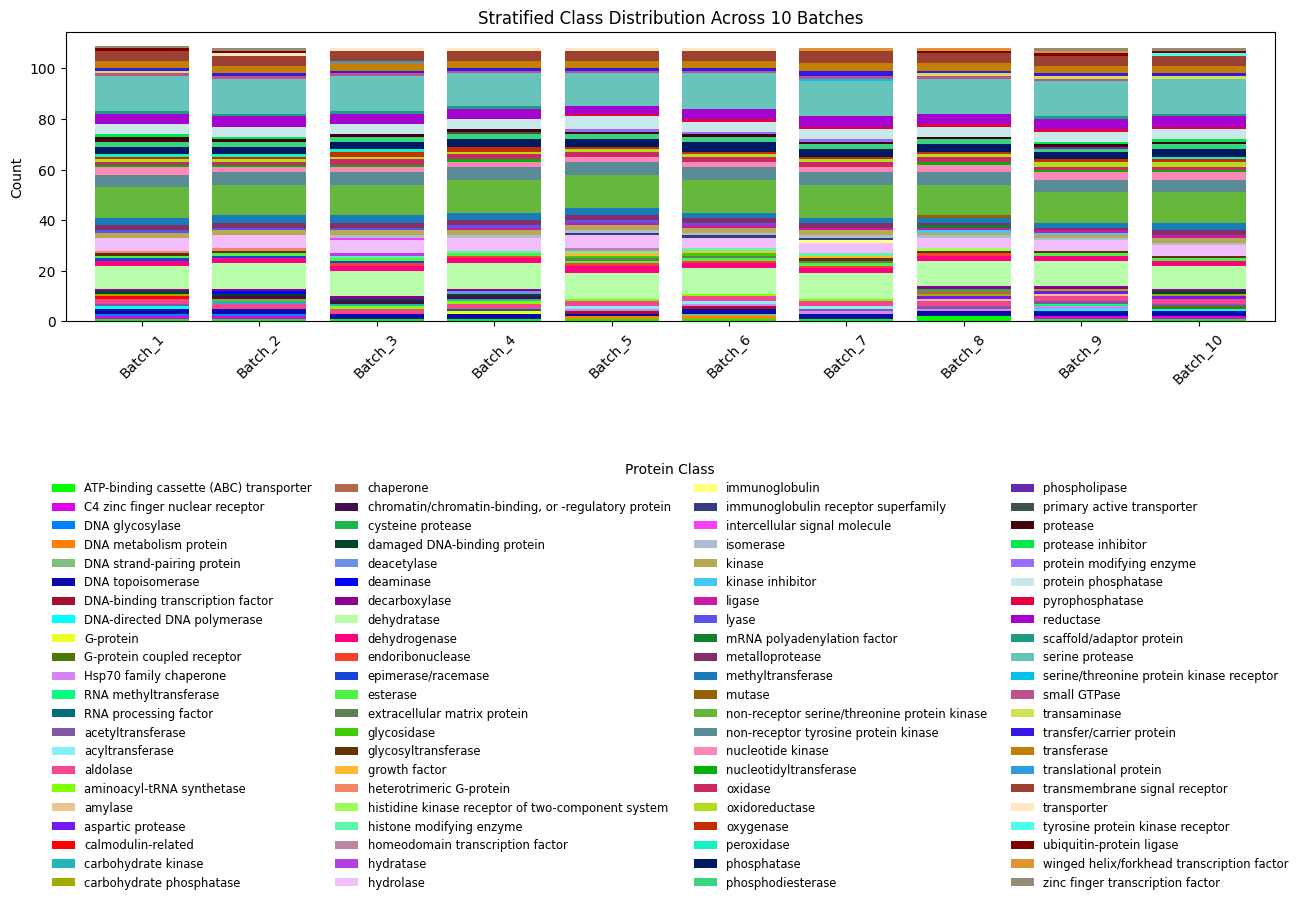

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold

# === Load data ===
df_all = pd.read_csv("pdb_to_panther_filtered.csv")
df_all = df_all.dropna(subset=["Panther_Protein_Class"])  # ensure class exists
df_all = df_all.drop_duplicates(subset="PDB_ID")
df_all = df_all.reset_index(drop=True)

# === Stratified Split into 10 Batches ===
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for i, (_, test_index) in enumerate(skf.split(df_all, df_all["Panther_Protein_Class"]), start=1):
    df_batch = df_all.iloc[test_index]
    df_batch.to_csv(f"batch_{i}_balanced.csv", index=False)

print(" Stratified batches saved.")

# === Summary Table Construction ===
summary = {}
df_classes = df_all.set_index("PDB_ID")  # reference class annotation

for i in range(1, 11):
    batch_file = f"batch_{i}_balanced.csv"
    if not os.path.exists(batch_file):
        print(f" Missing: {batch_file}")
        continue

    df_batch = pd.read_csv(batch_file)
    # Drop class column from batch to avoid merge duplication
    if "Panther_Protein_Class" in df_batch.columns:
        df_batch = df_batch.drop(columns=["Panther_Protein_Class"])

    # Merge to get class info
    df_merged = df_batch.merge(df_classes[["Panther_Protein_Class"]], on="PDB_ID", how="left")

    class_counts = df_merged["Panther_Protein_Class"].value_counts()
    summary[f"Batch_{i}"] = class_counts

# === Create summary DataFrame ===
summary_df = pd.DataFrame(summary).fillna(0).astype(int)
summary_df = summary_df.sort_index()

import distinctipy ### thi library creates a lot of different colors we need for the following plot 

# === Generate perceptually distinct colors for all classes ===
num_classes = len(summary_df)
colors = distinctipy.get_colors(num_classes)

import matplotlib.pyplot as plt

# === Plot ===
plt.figure(figsize=(14, 8))
num_classes = len(summary_df)
colors = distinctipy.get_colors(num_classes)  # or your own color list

ax = summary_df.T.plot(kind="bar", stacked=True, width=0.8, color=colors, figsize=(14, 12))

ax.set_ylabel("Count")
ax.set_title("Stratified Class Distribution Across 10 Batches")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Use `ax.legend()` not `plt.legend()`
ax.legend(
    title="Protein Class",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.45),
    ncol=4,
    fontsize="small",
    title_fontsize="medium",
    frameon=False
)

plt.tight_layout()
plt.savefig("class_distribution_plot.png", dpi=300)
plt.savefig("class_distribution_plot.pdf")
plt.savefig("class_distribution_plot.svg")
plt.show()





## Step 14: Organize batches in folders
Organize PDBs into their batch folder

In [ ]:
import os
import pandas as pd
import shutil

# Set folder with all PDBs
source_folder = "Truly_Final_PDBs"

# Loop through each batch CSV
for i in range(1, 11):
    batch_csv = f"batch_{i}_balanced.csv"
    target_folder = f"batch_{i}"
    os.makedirs(target_folder, exist_ok=True)

    if not os.path.isfile(batch_csv):
        print(f" Missing: {batch_csv}")
        continue

    df = pd.read_csv(batch_csv)
    if "PDB_ID" not in df.columns:
        print(f"No PDB_ID column in {batch_csv}")
        continue

    for pdb_code in df["PDB_ID"]:
        pdb_file = f"{pdb_code}.pdb"
        src_path = os.path.join(source_folder, pdb_file)
        dest_path = os.path.join(target_folder, pdb_file)

        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
        else:
            print(f"Not found: {pdb_file} in {source_folder}")

print("PDBs copied into batch folders.")


PDBs copied into batch folders.


## Step 15: PDB subfiles for Binding Sites
In the final preprocessing step, we generate PDB subfiles for each complex, containing only the residues that make up the binding site. These subfiles are essential for calculating Connolly surface points, which will later serve as input features for our machine learning model.

The following code performs this task. It reads the binding site information previously saved in CSV format, retrieves the coordinates of atoms belonging to the identified residues in each chain, and writes a new PDB file containing only the binding site. To reduce redundancy, homomeric chains are also removed at this stage.

Since this process is computationally intensive, we included detailed progress messages to provide real-time updates and make it easier to monitor execution.

In [ ]:
import os
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from Bio.SeqUtils import seq1
from Bio import pairwise2
from MDAnalysis import Universe
from MDAnalysis.analysis.distances import distance_array

# === CONFIGURATION ===
batch_root = "Final_Batches"  #Where batch_1 to batch_10 folders are
binding_sites_path = "binding_sites.csv"
pdb_extension = ".pdb"

# === MAPPINGS & FILTERING ===
alt_resname_map = {"HSD": "HIS", "HSE": "HIS", "HIP": "HIS", "MSE": "MET"}
valid_aa_3letter = {
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY",
    "HIS", "HSD", "HSE", "HIP", "ILE", "LEU", "LYS", "MET", "MSE",
    "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL", "SEC", "PYL"
}

def get_chain_sequence(residues):
    sequence = []
    for res in residues:
        resname = res.resname
        if resname in valid_aa_3letter:
            canonical = alt_resname_map.get(resname, resname)
            try:
                sequence.append(seq1(canonical))
            except Exception:
                continue
    return "".join(sequence)

def identify_unique_chain_ids(universe, ligand_residues=None, distance_cutoff=4.0):
    seen_sequences = []
    ligand_counts = Counter(res.resname for res in ligand_residues) if ligand_residues else Counter()
    singleton_ligands = {res for res, count in ligand_counts.items() if count == 1}
    ligand_nearby_chains = set()

    if ligand_residues:
        for ligand_res in ligand_residues:
            if ligand_res.resname not in singleton_ligands:
                continue
            ligand_atoms = ligand_res.atoms
            for seg in universe.segments:
                seg_atoms = seg.atoms.select_atoms("protein and not name H*")
                if len(seg_atoms) == 0:
                    continue
                try:
                    dists = distance_array(ligand_atoms.positions, seg_atoms.positions)
                    if np.any(dists < distance_cutoff):
                        ligand_nearby_chains.add(seg.segid)
                except Exception:
                    continue

    unique_chain_ids = []
    for seg in universe.segments:
        seq = get_chain_sequence(seg.residues)
        if not seq:
            continue
        is_duplicate = False
        for seen_seq in seen_sequences:
            alignments = pairwise2.align.globalxx(seq, seen_seq)
            identity = alignments[0][2] / max(len(seq), len(seen_seq))
            if identity >= 0.99:
                is_duplicate = True
                break
        if not is_duplicate or seg.segid in ligand_nearby_chains:
            seen_sequences.append(seq)
            unique_chain_ids.append(seg.segid)
    return unique_chain_ids

def save_selection(universe, selection, out_path):
    atoms = universe.select_atoms(selection)
    print(f"         Trying selection: {selection} → {atoms.n_atoms} atoms")
    if atoms.n_atoms > 0:
        atoms.write(out_path)
        print(f"         Saved: {os.path.basename(out_path)}")
    else:
        print(f"         Skipped (no atoms)")

# === LOAD BINDING SITES ===
print("Loading binding_sites.csv...")
df_bs = pd.read_csv(binding_sites_path)
print(f"   {len(df_bs)} binding site rows loaded.\n")

# === PROCESS BATCHES ===
for batch in [f"batch_{i}" for i in range(1, 11)]:
    batch_path = os.path.join(batch_root, batch)
    if not os.path.isdir(batch_path):
        print(f"Missing folder: {batch}")
        continue

    print(f"\nProcessing {batch}...")

    for filename in os.listdir(batch_path):
        if not filename.endswith(pdb_extension):
            continue

        pdb_id = filename.replace(pdb_extension, "")
        pdb_path = os.path.join(batch_path, filename)

        print(f"\n{pdb_id}:")
        try:
            u = Universe(pdb_path)
        except Exception as e:
            print(f"   Failed to load PDB: {e}")
            continue

        print(f"   Universe loaded: {u.atoms.n_atoms} atoms")

        # === REMOVE HOMOMERIC CHAINS ===
        ligand_residues = u.select_atoms("not protein and not name H*").residues
        unique_chains = identify_unique_chain_ids(u, ligand_residues)
        chain_sel = "segid " + " ".join(unique_chains)

        atoms_to_keep = u.select_atoms(chain_sel)
        if atoms_to_keep.n_atoms > 0:
            atoms_to_keep.write(pdb_path)
            print(f"   Homomer-filtered PDB saved ({len(unique_chains)} chain(s))")
        else:
            print(f"   No valid chains retained. Skipping binding site extraction.")
            continue

        # === EXTRACT BINDING SITES ===
        bs_rows = df_bs[df_bs["pdb_id"] == pdb_id]
        if bs_rows.empty:
            print(f"   No binding site data for {pdb_id}")
            continue

        print(f"   Found {len(bs_rows)} binding site region(s)")

        for i, row in bs_rows.iterrows():
            try:
                res_text = str(row.get("binding_residues", "")).strip("[]")
                if not res_text or res_text.lower() == "nan":
                    print(f"      Row {i}: no binding_residues provided")
                    continue

                entries = [r.strip() for r in res_text.split(";") if "_" in r]
                residues = []

                for entry in entries:
                    parts = entry.split("_")
                    if len(parts) == 3:
                        _, resid, _ = parts
                        if resid.isdigit():
                            residues.append(resid)

                if not residues:
                    print(f"      Row {i}: no valid residues found")
                    continue

                sel = f"resid {' '.join(residues)}"
                bs_out = os.path.join(batch_path, f"{pdb_id}_bs_{i}.pdb")
                save_selection(u, sel, bs_out)

            except Exception as e:
                print(f"      Failed to extract BS row {i}: {e}")
